# Calculating the codon adaptation index

In [1]:
"""
MicroLive Notebook
==================
This notebook requires MicroLive to be installed:
    pip install tasep_models

For development mode:
    pip install -e /path/to/tasep_models
"""
# MicroLive imports
import tasep_models as tm


# Verify GPU support
# check_gpu_status() # GPU check removed

# Standard scientific imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


<module 'ML_SpotDetection' from '/Users/nzlab-la/Desktop/microlive/src/ML_SpotDetection.py'>

In [2]:
import tasep_models
from pathlib import Path
# Auto-detected path from library
human_genome_path = tasep_models.HUMAN_GENOME_PATH


In [3]:
from collections import defaultdict
def compute_codon_frequencies_from_genome(genome_path):
    """
    Parse human CDS sequences and compute codon frequencies.
    Returns a dictionary of codon counts.
    """
    codon_counts = defaultdict(int)
    total_codons = 0
    valid_sequences = 0
    
    print(f"Reading CDS sequences from: {genome_path}")
    
    for rec in SeqIO.parse(genome_path, "fasta"):
        seq = str(rec.seq).upper()
        
        # Skip invalid sequences
        if len(seq) % 3 != 0:
            continue
        if not re.fullmatch(r"[ACGT]+", seq):
            continue
        
        valid_sequences += 1
        
        # Count codons
        for i in range(0, len(seq) - 2, 3):
            codon = seq[i:i+3]
            if len(codon) == 3:
                codon_counts[codon] += 1
                total_codons += 1
    
    print(f"Processed {valid_sequences} valid CDS sequences")
    print(f"Total codons counted: {total_codons}")
    
    return dict(codon_counts)

def compute_relative_adaptiveness(codon_counts):
    """
    Compute relative adaptiveness weights (w_i = count_i / max_count_for_aa)
    Returns dictionary: {codon: weight}
    """
    GENETIC_CODE = {
        'TTT':'F','TTC':'F','TTA':'L','TTG':'L',
        'CTT':'L','CTC':'L','CTA':'L','CTG':'L',
        'ATT':'I','ATC':'I','ATA':'I','ATG':'M',
        'GTT':'V','GTC':'V','GTA':'V','GTG':'V',
        'TCT':'S','TCC':'S','TCA':'S','TCG':'S',
        'CCT':'P','CCC':'P','CCA':'P','CCG':'P',
        'ACT':'T','ACC':'T','ACA':'T','ACG':'T',
        'GCT':'A','GCC':'A','GCA':'A','GCG':'A',
        'TAT':'Y','TAC':'Y','TAA':'*','TAG':'*',
        'CAT':'H','CAC':'H','CAA':'Q','CAG':'Q',
        'AAT':'N','AAC':'N','AAA':'K','AAG':'K',
        'GAT':'D','GAC':'D','GAA':'E','GAG':'E',
        'TGT':'C','TGC':'C','TGA':'*','TGG':'W',
        'CGT':'R','CGC':'R','CGA':'R','CGG':'R',
        'AGT':'S','AGC':'S','AGA':'R','AGG':'R',
        'GGT':'G','GGC':'G','GGA':'G','GGG':'G'
    }
    
    # Group codons by amino acid
    aa_to_codons = defaultdict(list)
    for codon, aa in GENETIC_CODE.items():
        aa_to_codons[aa].append(codon)
    
    # Compute weights
    weights = {}
    for aa, codons in aa_to_codons.items():
        # Get max count for this amino acid
        max_count = max(codon_counts.get(c, 0) for c in codons)
        
        if max_count > 0:
            for codon in codons:
                count = codon_counts.get(codon, 0)
                weights[codon] = count / max_count
        else:
            # No data for this amino acid, set weight to 0
            for codon in codons:
                weights[codon] = 0.0
    
    return weights

def format_python_dict(weights):
    """
    Format the weights dictionary as a Python code string for copy-paste.
    """
    lines = ["# Human codon relative adaptiveness weights"]
    lines.append("# Computed from Homo_sapiens.GRCh38.cds.all.fa")
    lines.append("# Generated using BioPython CodonAdaptationIndex approach")
    lines.append("")
    lines.append("HUMAN_CODON_WEIGHTS = {")
    
    # Sort by codon for readability
    sorted_codons = sorted(weights.keys())
    
    # Group by first nucleotide for better formatting
    current_first = None
    for codon in sorted_codons:
        if codon[0] != current_first:
            if current_first is not None:
                lines.append("")
            current_first = codon[0]
        
        weight = weights[codon]
        lines.append(f"    '{codon}': {weight:.6f},")
    
    lines.append("}")
    
    return "\n".join(lines)

    

In [4]:
# calculating codon frequencies using the human genome CDS.
import tasep_models
from pathlib import Path
# Auto-detected path from library
human_genome_path = tasep_models.HUMAN_GENOME_PATH
    
print("\n" + "="*60)
print("Counting codons from human CDS sequences")
print("="*60)
codon_counts = compute_codon_frequencies_from_genome(human_genome_path)

print("\n" + "="*60)
print("Computing relative adaptiveness weights")
print("="*60)
weights = compute_relative_adaptiveness(codon_counts)

print("\n" + "="*60)
print("Generating Python dictionary")
print("="*60)
python_code = format_python_dict(weights)

output_file = Path('human_codon_weights.py')
with open(output_file, 'w') as f:
    f.write(python_code)

print(f"\n✓ Saved to: {output_file}")
print("\n" + "="*60)

json_file = Path('human_codon_weights.json')
with open(json_file, 'w') as f:
    json.dump(weights, f, indent=2)
print(f"\n Frequency of adaptiveness weights saved as JSON: {json_file}")



Counting codons from human CDS sequences
Reading CDS sequences from: /Users/nzlab-la/Desktop/microlive/modeling/TASEP/human_genome/Homo_sapiens.GRCh38.cds.all.fa
Processed 99066 valid CDS sequences
Total codons counted: 43501989

Computing relative adaptiveness weights

Generating Python dictionary

✓ Saved to: human_codon_weights.py


 Frequency of adaptiveness weights saved as JSON: human_codon_weights.json


In [5]:
HUMAN_CODON_WEIGHTS = json.load(open('human_codon_weights.json')    )

In [6]:

def compute_CAI_from_precomputed_weights(sequence, weights=HUMAN_CODON_WEIGHTS):
    """
    Corrected version that matches BioPython's calculation method.
    Key fix: Exclude Met (ATG) and Trp (TGG) which have only one codon.
    """
    import math
    
    sequence = sequence.upper().replace("U", "T")
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    
    # Codons to exclude (following Sharp & Li 1987 convention)
    STOP_CODONS = {'TAA', 'TAG', 'TGA'}
    SINGLE_CODON_AA = {'ATG', 'TGG'}  # Met and Trp - only one codon each
    
    valid_weights = []
    
    for i, codon in enumerate(codons):
        # Skip first codon (start)
        if i == 0:
            continue
        
        # Skip stop codons
        if codon in STOP_CODONS:
            continue
        
        # Skip single-codon amino acids (no codon choice)
        if codon in SINGLE_CODON_AA:
            continue
        
        # Only include if weight exists and is positive
        if codon in weights and weights[codon] > 0:
            valid_weights.append(weights[codon])
    
    if not valid_weights:
        return 0.0
    
    # Geometric mean
    return math.exp(sum(math.log(w) for w in valid_weights) / len(valid_weights))

In [7]:

test_gene = 'AUGUAUCCUUACGAUGUACCCGACUACGCUGGCUAUCCAUACGACGUUCCGGAUUAUGCCGGAUACCCAUAUGAUGUACCCGAUUACGCGGGCGGAAACUCACUGAUCAAGGAAAACAUGCGGAUGAAGGUGGUGAUGGAGGGCUCCGUGAAUGGUCACCAGUUCAAGUGCACCGGAGAGGGAGAGGGAAACCCGUACAUGGGAACUCAGACCAUGCGCAUUAAGGUCAUCGAAGGAGGUCCGCUGCCGUUCGCUUUCGAUAUCCUGGCCACUUCGUUCGGAGGAGGGUCGCGCACGUUCAUCAAGUACCCGAAGGGAAUCCCGGACUUCUUUAAGCAGUCAUUCCCGGAAGGAUUCACUUGGGAACGGGUGACCCGGUAUGAAGAUGGAGGUGUGGUGACUGUCAUGCAAGAUACUUCGCUGGAGGAUGGGUGCCUCGUGUACCACGUCCAAGUCCGCGGAGUGAAUUUCCCGUCCAACGGACCAGUGAUGCAGAAAAAGACGAAGGGUUGGGAACCUAAUACUGAAAUGAUGUACCCCGCAGACGGAGGGCUGAGGGGCUACACCCACAUGGCGCUGAAGGUCGACGGAGGAUAUCCCUACGACGUGCCCGAUUAUGCGCAACAAUAUCCGUAUGAUGUUCCAGAUUAUGCUGGCCAGCAGGGCUAUCCCUAUGAUGUCCCCGACUACGCCCAGCAGUACCCAUACGACGUUCCCGACUACGCAGGAGGAGGACAUCUGUCCUGUUCGUUCGUGACCACCUACAGAUCAAAGAAAACCGUGGGAAACAUCAAGAUGCCGGGCAUUCAUGCCGUCGACCACCGCCUGGAGCGGCUCGAAGAAUCAGACAAUGAGAUGUUCGUCGUGCAAAGAGAACAUGCCGUGGCCAAGUUCGCGGGACUGGGAGGCGGUGGAGGCUACCCCUACGAUGUGCCGGAUUACGCUGGAUAUCCGUAUGACGUACCGGACUAUGCCGGUUACCCGUACGAUGUCCCGGACUACGCUGGAGGCGGUGGAUCAGGUGGAGGAGGUUCACUGCAGGGACGCGUAGGUUCGGGUUCGAAAGGUGAAGAACUAUUUACGGGUGUAGUACCGAUACUAGUAGAACUAGAUGGUGAUGUAAAUGGUCAUAAAUUUUCGGUAUCGGGUGAAGGUGAAGGUGAUGCGACGUAUGGUAAACUAACGCUAAAAUUUAUAUGUACGACGGGUAAACUACCGGUACCGUGGCCGACGCUAGUAACGACGUUUUCGUAUGCGGUACAAUGUUUUUCGCGUUAUCCGGAUCAUAUGAAACGUCAUGAUUUUUUUAAAUCGGCGAUGCCGGAAGGUUAUGUACAAGAACGUACGAUAUCGUUUAAAGAUGAUGGUAAUUAUAAAACGCGAGCGGAAGUAAAAUUUGAAGGUGAUACGCUAGUAAACCGUAUAGAGCUAAAGGGUAUAGACUUCAAGGAAGAUGGUAACAUACUAGGUCACAAGCUAGAGUACAACUACAACUCGCACAACGUAUAUAUAACGGCGGAUAAGCAAAAGAAUGGUAUAAAGGCGAAUUUCAAGAUACGUCACAAUAUAGAAGAUGGUUCGGUACAACUAGCGGAUCACUAUCAACAAAAUACGCCGAUAGGUGAUGGUCCGGUACUACUACCGGAUAAUCAUUAUCUAUCGACGCAAUCGAAACUAUCGAAAGAUCCGAAUGAAAAACGUGAUCAUAUGGUACUACUAGAAUUUGUAACGGCGGCGGGUAUAACGCAUGGUAUGGAUGAACUAUAUAAAGGUUCGGGGCGCGUAGGUUCGGGUUCGAAAGGUGAAGAACUAUUUACGGGUGUAGUACCGAUACUAGUAGAACUAGAUGGUGAUGUAAAUGGUCAUAAAUUUUCGGUAUCGGGUGAAGGUGAAGGUGAUGCGACGUAUGGUAAACUAACGCUAAAAUUUAUAUGUACGACGGGUAAACUACCGGUACCGUGGCCGACGCUAGUAACGACGUUUUCGUAUGCGGUACAAUGUUUUUCGCGUUAUCCGGAUCAUAUGAAACGUCAUGAUUUUUUUAAAUCGGCGAUGCCGGAAGGUUAUGUACAAGAACGUACGAUAUCGUUUAAAGAUGAUGGUAAUUAUAAAACGCGAGCGGAAGUAAAAUUUGAAGGUGAUACGCUAGUAAACCGUAUAGAGCUAAAGGGUAUAGACUUCAAGGAAGAUGGUAACAUACUAGGUCACAAGCUAGAGUACAACUACAACUCGCACAACGUAUAUAUAACGGCGGAUAAGCAAAAGAAUGGUAUAAAGGCGAAUUUCAAGAUACGUCACAAUAUAGAAGAUGGUUCGGUACAACUAGCGGAUCACUAUCAACAAAAUACGCCGAUAGGUGAUGGUCCGGUACUACUACCGGAUAAUCAUUAUCUAUCGACGCAAUCGAAACUAUCGAAAGAUCCGAAUGAAAAACGUGAUCAUAUGGUACUACUAGAAUUUGUAACGGCGGCGGGUAUAACGCAUGGUAUGGAUGAACUAUAUAAAGGUUCGGGGCGCGUAGGUUCGGGUUCGAAAGGUGAAGAACUAUUUACGGGUGUAGUACCGAUACUAGUAGAACUAGAUGGUGAUGUAAAUGGUCAUAAAUUUUCGGUAUCGGGUGAAGGUGAAGGUGAUGCGACGUAUGGUAAACUAACGCUAAAAUUUAUAUGUACGACGGGUAAACUACCGGUACCGUGGCCGACGCUAGUAACGACGUUUUCGUAUGCGGUACAAUGUUUUUCGCGUUAUCCGGAUCAUAUGAAACGUCAUGAUUUUUUUAAAUCGGCGAUGCCGGAAGGUUAUGUACAAGAACGUACGAUAUCGUUUAAAGAUGAUGGUAAUUAUAAAACGCGAGCGGAAGUAAAAUUUGAAGGUGAUACGCUAGUAAACCGUAUAGAGCUAAAGGGUAUAGACUUCAAGGAAGAUGGUAACAUACUAGGUCACAAGCUAGAGUACAACUACAACUCGCACAACGUAUAUAUAACGGCGGAUAAGCAAAAGAAUGGUAUAAAGGCGAAUUUCAAGAUACGUCACAAUAUAGAAGAUGGUUCGGUACAACUAGCGGAUCACUAUCAACAAAAUACGCCGAUAGGUGAUGGUCCGGUACUACUACCGGAUAAUCAUUAUCUAUCGACGCAAUCGAAACUAUCGAAAGAUCCGAAUGAAAAACGUGAUCAUAUGGUACUACUAGAAUUUGUAACGGCGGCGGGUAUAACGCAUGGUAUGGAUGAACUAUAUAAAGGUUCGGGGCGCGUAGGUUCGGGUUCGAAAGGUGAAGAACUAUUUACGGGUGUAGUACCGAUACUAGUAGAACUAGAUGGUGAUGUAAAUGGUCAUAAAUUUUCGGUAUCGGGUGAAGGUGAAGGUGAUGCGACGUAUGGUAAACUAACGCUAAAAUUUAUAUGUACGACGGGUAAACUACCGGUACCGUGGCCGACGCUAGUAACGACGUUUUCGUAUGCGGUACAAUGUUUUUCGCGUUAUCCGGAUCAUAUGAAACGUCAUGAUUUUUUUAAAUCGGCGAUGCCGGAAGGUUAUGUACAAGAACGUACGAUAUCGUUUAAAGAUGAUGGUAAUUAUAAAACGCGAGCGGAAGUAAAAUUUGAAGGUGAUACGCUAGUAAACCGUAUAGAGCUAAAGGGUAUAGACUUCAAGGAAGAUGGUAACAUACUAGGUCACAAGCUAGAGUACAACUACAACUCGCACAACGUAUAUAUAACGGCGGAUAAGCAAAAGAAUGGUAUAAAGGCGAAUUUCAAGAUACGUCACAAUAUAGAAGAUGGUUCGGUACAACUAGCGGAUCACUAUCAACAAAAUACGCCGAUAGGUGAUGGUCCGGUACUACUACCGGAUAAUCAUUAUCUAUCGACGCAAUCGAAACUAUCGAAAGAUCCGAAUGAAAAACGUGAUCAUAUGGUACUACUAGAAUUUGUAACGGCGGCGGGUAUAACGCAUGGUAUGGAUGAACUAUAUAAAGGUUCGGGGCGCGUAGGUUCGGGUGGUGUAUCGAAAGGUGAGGAAGAUAAUAUGGCGAUAAUAAAAGAGUUUAUGCGUUUUAAAGUACAUAUGGAAGGUUCGGUAAAUGGUCAUGAGUUUGAGAUAGAAGGUGAAGGUGAAGGUCGUCCGUAUGAAGGUACGCAAACGGCGAAACUAAAAGUAACGAAAGGUGGUCCGCUACCGUUUGCGUGGGAUAUACUAUCGCCGCAAUUUAUGUAUGCGUCGAAAGCGUAUGUAAAACAUCCGGCGGAUAUACCGGAUUAUCUAAAACUAUCGUUUCCGGAAGGUUUUAAAUGGGAACGUGUAAUGAAUUUUGAAGAUGGUGGUGUAGUAACGGUAACGCAAGAUUCGUCGCUACAAGAUGGUGAAUUUAUAUAUAAAGUAAAACUACGUGGUACGAAUUUUCCGUCGGAUGGUCCGGUAAUGCAAAAAAAAACGAUGGGUUGGGAAGCGUCGUCGGAACGUAUGUAUCCGGAAGAUGGUGCGCUAAAAGGUGAAAUAAAACAACGUCUAAAACUAAAAGAUGGUGGUCAUUAUGAUGCGGAAGUAAAAACGACGUAUAAAGCGAAAAAACCGGUACAACUACCGGGUGCGUAUAAUGUAAAUAUAAAACUAGAUAUAACGUCGCAUAAUGAAGAUUAUACGAUAGUAGAACAAUAUGAACGUGCGGAAGGUCGUCAUUCGACGGGUGGUAUGGAUGAACUAUAUAAAGGUGGUUCGGGGCGCGUAGGUUCGGGUGGUGUAUCGAAAGGUGAGGAAGAUAAUAUGGCGAUAAUAAAAGAGUUUAUGCGUUUUAAAGUACAUAUGGAAGGUUCGGUAAAUGGUCAUGAGUUUGAGAUAGAAGGUGAAGGUGAAGGUCGUCCGUAUGAAGGUACGCAAACGGCGAAACUAAAAGUAACGAAAGGUGGUCCGCUACCGUUUGCGUGGGAUAUACUAUCGCCGCAAUUUAUGUAUGCGUCGAAAGCGUAUGUAAAACAUCCGGCGGAUAUACCGGAUUAUCUAAAACUAUCGUUUCCGGAAGGUUUUAAAUGGGAACGUGUAAUGAAUUUUGAAGAUGGUGGUGUAGUAACGGUAACGCAAGAUUCGUCGCUACAAGAUGGUGAAUUUAUAUAUAAAGUAAAACUACGUGGUACGAAUUUUCCGUCGGAUGGUCCGGUAAUGCAAAAAAAAACGAUGGGUUGGGAAGCGUCGUCGGAACGUAUGUAUCCGGAAGAUGGUGCGCUAAAAGGUGAAAUAAAACAACGUCUAAAACUAAAAGAUGGUGGUCAUUAUGAUGCGGAAGUAAAAACGACGUAUAAAGCGAAAAAACCGGUACAACUACCGGGUGCGUAUAAUGUAAAUAUAAAACUAGAUAUAACGUCGCAUAAUGAAGAUUAUACGAUAGUAGAACAAUAUGAACGUGCGGAAGGUCGUCAUUCGACGGGUGGUAUGGAUGAACUAUAUAAAGGUGGUUCGGGGCGCGCCGGUUCGGGUCAUAUGUAG' # start codon (ignored) + alanine codons
test_gene = test_gene.upper().replace("U", "T")


In [8]:
# test using CodonAdaptationIndex class from BioPython
valid_seqs = []
for rec in SeqIO.parse(human_genome_path, "fasta"):
    seq = str(rec.seq).upper()
    if len(seq) % 3 != 0:
        continue
    if not re.fullmatch(r"[ACGT]+", seq):
        continue
    valid_seqs.append(seq)
cai_calc = CodonAdaptationIndex(valid_seqs)
score = cai_calc.calculate(test_gene)
print(f"Test gene CAI score: {score:.3f}")


Test gene CAI score: 0.539


In [9]:
# test using the precomputed weights
cai_score = compute_CAI_from_precomputed_weights(test_gene)
print(f"Test gene CAI score: {cai_score:.3f}")

Test gene CAI score: 0.539


In [10]:
# Final implementation code in TASEP models
cai_score = compute_CAI(test_gene)
print(f"Test gene CAI score: {cai_score:.3f}")

Test gene CAI score: 0.539


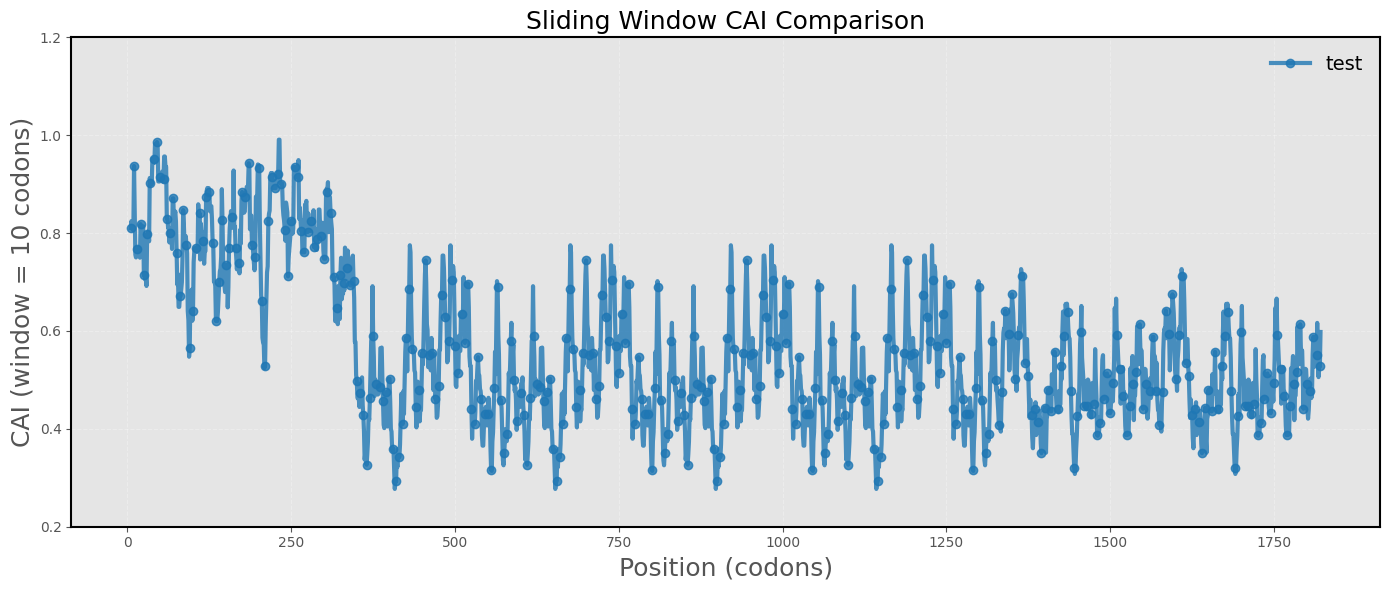

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Sliding Window CAI Comparison'}, xlabel='Position (codons)', ylabel='CAI (window = 10 codons)'>)

In [ ]:
window_size =10
step_size=1

plot_sliding_window_cai(
    sequences=test_gene,
    sequence_names=['test'],
    window_size=window_size,
    step=step_size,
    figsize=(14, 6),
    save_path=None  # Or: save_path='sliding_window_cai.png'
)